In [1]:
import pandas as pd
df = pd.read_csv('../dataset/DBPEDIA_train.csv')
document_list = df['text'].to_numpy().astype('str')
document_list.dtype

dtype('<U3944')

In [2]:
# # Tokenizeing documents
# from transformers import BertTokenizer
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# encoded_list = []

# for i, doc in enumerate(document_list):
#     encoded = tokenizer.encode_plus(doc, add_special_tokens=True, max_length=512)
#     encoded_list.append(encoded)

In [3]:
# encoding topics to create the adjacency matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np

labelEncoder = LabelEncoder()
topics = np.concatenate((df['l1'].unique(), df['l2'].unique(), df['l3'].unique()))
labelEncoder.fit(topics)

def encode_topic(topic):
    print(type(topic))
    return labelEncoder.transform(topic)

df['l1_encoded'] = labelEncoder.transform(df['l1'])
df['l2_encoded'] = labelEncoder.transform(df['l2'])
df['l3_encoded'] = labelEncoder.transform(df['l3'])


In [4]:
from transformers import BertTokenizer
import numpy as np
import re

max_len = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_topic_to_tokenized_dict = {}
for topic in topics:
    # dbpedia categories are in PascalCase, so this makes them spaced
    spaced_words = re.sub( r"([A-Z])", r" \1", topic)[1:]
    tokenized_sequence = tokenizer.encode_plus(spaced_words, add_special_tokens=True, max_length=max_len, padding='max_length')['input_ids']

    encoded_topic_to_tokenized_dict[labelEncoder.transform([topic])[0]] = tokenized_sequence

In [5]:
# documents = df['text'].apply(lambda doc: np.array(tokenizer.encode_plus(doc, add_special_tokens=True, max_length=max_len, padding='max_length', truncation=True)['input_ids'])).to_numpy()
# documents_labels = labelEncoder.transform(df['l3'].to_numpy())
# documents_fixed = np.empty(shape=(len(documents), max_len))
# for i, doc in enumerate(documents):
#     documents_fixed[i] = doc

In [6]:
# import pickle
# with open("tokenized_dbpedia.pkl", "wb") as f:
#     pickle.dump([documents_fixed, documents_labels], f)

In [7]:
import pickle

with (open("./tokenized_dbpedia.pkl", "rb")) as f:
    documents, documents_labels = pickle.load(f)

In [8]:
graph_dict = {}

for i, row in df.iterrows():
    l1 = row['l1_encoded']
    l2 = row['l2_encoded']
    l3 = row['l3_encoded']

    if l1 not in graph_dict:
        graph_dict[l1] = {}
    if l2 not in graph_dict[l1]:
        graph_dict[l1][l2] = {} 

    graph_dict[l1][l2][l3] = 1

In [9]:
# creating adjacency matrix
adj_matrix = np.zeros((len(topics), len(topics)))
square_numeric_dict = {'source': [], 'target': []}
for i, df_row in df.iterrows():
    l1 = df_row['l1_encoded']
    l2 = df_row['l2_encoded']
    l3 = df_row['l3_encoded']

    adj_matrix[l1, l2] = 1
    adj_matrix[l2, l3] = 1

for i, row in enumerate(adj_matrix):
    for j, value in enumerate(row):
        if value == 0:
            continue
        square_numeric_dict['source'].append(i)
        square_numeric_dict['target'].append(j)

square_numeric_edges = pd.DataFrame(square_numeric_dict)

In [10]:
# creating node features
x = np.arange(298)
x = labelEncoder.inverse_transform(x)
feature_array = x.reshape(298, -1)

In [11]:
# loading GloVe model to get topic word embeddings
# from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
import torchtext

glove = torchtext.vocab.GloVe(name="6B", dim=50)

In [12]:
# Creating "ego-graphs" (each node is seperated into a graph with itself, parent, and siblings)
# The base node (so the node itself) will be masked, aka. have a [MASK] embedding
# The sibling nodes need to have a negative relationship with the base node (so negative value in adjacency matrix?)
from spektral.data import Graph
import numpy as np
import re
def create_ego_graph(l1_topic, l2_topic, l3_topic, graph_dict):
    if l3_topic != None:
        siblings_list = list(graph_dict[l1_topic][l2_topic].keys())
        siblings_list.remove(l3_topic)
        base = l3_topic
        parent = l2_topic
        grandparent = l1_topic

        all_nodes_list = siblings_list.copy()
        all_nodes_list.append(base)
        all_nodes_list.append(parent)
        all_nodes_list.append(grandparent)
        
        n_nodes = len(all_nodes_list)
        adj_matrix = np.zeros((n_nodes, n_nodes))

        node_label_encoder = LabelEncoder()
        node_label_encoder.fit(all_nodes_list)
        
        encoded_base = node_label_encoder.transform([base])[0]
        encoded_parent = node_label_encoder.transform([parent])[0]
        encoded_grandparent = node_label_encoder.transform([grandparent])[0]

        adj_matrix[encoded_base][encoded_parent] = 1
        adj_matrix[encoded_parent][encoded_base] = 1

        adj_matrix[encoded_grandparent][encoded_parent] = 1
        adj_matrix[encoded_parent][encoded_grandparent] = 1

        for sibling in siblings_list: 
            encoded_sibling = node_label_encoder.transform([sibling])[0]
            adj_matrix[encoded_sibling][encoded_base] = -1
            adj_matrix[encoded_base][encoded_sibling] = -1
        
    elif l2_topic != None:
        siblings_list = list(graph_dict[l1_topic].keys())
        siblings_list.remove(l2_topic)
        base = l2_topic
        parent = l1_topic

        all_nodes_list = siblings_list.copy()
        all_nodes_list.append(base)
        all_nodes_list.append(parent)
        
        n_nodes = len(all_nodes_list)
        adj_matrix = np.zeros((n_nodes, n_nodes))

        node_label_encoder = LabelEncoder()
        node_label_encoder.fit(all_nodes_list)
        
        encoded_base = node_label_encoder.transform([base])[0]
        encoded_parent = node_label_encoder.transform([parent])[0]

        adj_matrix[encoded_base][encoded_parent] = 1
        adj_matrix[encoded_parent][encoded_base] = 1

        for sibling in siblings_list: 
            encoded_sibling = node_label_encoder.transform([sibling])[0]
            adj_matrix[encoded_sibling][encoded_base] = -1
            adj_matrix[encoded_base][encoded_sibling] = -1
    
    elif l1_topic != None:
        siblings_list = list(graph_dict.keys())
        siblings_list.remove(l1_topic)
        base = l1_topic

        all_nodes_list = siblings_list.copy()
        all_nodes_list.append(base)
        
        n_nodes = len(all_nodes_list)
        adj_matrix = np.zeros((n_nodes, n_nodes))

        node_label_encoder = LabelEncoder()
        node_label_encoder.fit(all_nodes_list)
        
        encoded_base = node_label_encoder.transform([base])[0]

        for sibling in siblings_list: 
            encoded_sibling = node_label_encoder.transform([sibling])[0]
            adj_matrix[encoded_sibling][encoded_base] = -1
            adj_matrix[encoded_base][encoded_sibling] = -1

    ego_features = np.zeros((n_nodes, 50))
    encoded_nodes_list = node_label_encoder.transform(all_nodes_list)

    for i, node in enumerate(all_nodes_list):
        feature = feature_array[node]
        split_words_list = re.sub( r"([A-Z])", r" \1", feature[0]).split()
        n_words = len(split_words_list)
        embedding_avg = np.array([glove[word.lower()].numpy() for word in split_words_list]).sum(axis=0)/n_words
        
        # Masking base node, setting the embedding to all 0's
        if (node == base):
            embedding_avg = glove['MASK']

        ego_features[encoded_nodes_list[i]] = embedding_avg

    return Graph(a=adj_matrix, x=ego_features, y=(l1_topic, l2_topic, l3_topic))

graph_list = []

for l1_topic in graph_dict:
    for l2_topic in graph_dict[l1_topic]:
        for l3_topic in graph_dict[l1_topic][l2_topic]:
            graph_list.append(create_ego_graph(l1_topic, l2_topic, l3_topic, graph_dict))
        graph_list.append(create_ego_graph(l1_topic, l2_topic, None, graph_dict))
    graph_list.append(create_ego_graph(l1_topic, None, None, graph_dict))

graph_list = np.array(graph_list)

In [13]:
from spektral.data import Dataset

class MyDataset(Dataset):
    """
    """
    def __init__(self, graph_list: list[Graph], **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)

    def read(self):
        # We must return a list of Graph objects
        num_l =  np.random.permutation(len(self.graph_list))
        return [self.graph_list[i] for i in num_l]
    
dataset = MyDataset(graph_list)

In [14]:
# from spektral.data import DisjointLoader, SingleLoader
# from transformers import BertTokenizer

# learning_rate = 1e-3  # Learning rate
# epochs = 20  # Number of training epochs
# batch_size = 32  # Batch size

# # Train/test split
# np.random.shuffle(dataset)
# split = int(0.6 * len(dataset))
# data_tr, data_te = dataset[:split], dataset[split:]

# loader_tr = DisjointLoader(data_tr, batch_size=1, epochs=epochs)
# loader_te = DisjointLoader(data_te, batch_size=1,)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [15]:
# Code from the tensorflow_ranking source code
# Source: https://github.com/tensorflow/ranking/blob/v0.5.2/tensorflow_ranking/python/keras/layers.py#L806-L891
# Need to modify code since the original implementation only takes two embeddings of the SAME shape
# For this case however, the topic embedding and the BERT embedding have two different shapes (50 x 768)
import tensorflow as tf

class Bilinear(tf.keras.layers.Layer):
  """A Keras Layer makes bilinear interaction of two vectors.
  This Keras Layer implements the bilinear interaction of two vectors of
  embedding dimensions. The bilinear, linear and scalar parameters of the
  interaction are trainable.
  The bilinear interaction are used in the work "Revisiting two tower models
  for unbiased learning to rank" by Yan et al, see
  https://research.google/pubs/pub51296/.
  In this work, the bilinear interaction appears to be helpful in model the
  complex interaction between position and relevance in unbiased LTR.
  """

  def __init__(self, embedding1_dim: int, embedding2_dim: int, output_dim: int, **kwargs: dict[any,
                                                                         any]):
    """Initializer.
    Args:
      embedding_dim: An integer that indicates the embedding dimension of the
        interacting vectors.
      output_dim: An integer that indicates the output dimension of the layer.
      **kwargs: A dict of keyword arguments for the tf.keras.layers.Layer.
    """
    super().__init__(**kwargs)
    self._embedding1_dim = embedding1_dim
    self._embedding2_dim = embedding2_dim
    self._output_dim = output_dim

  def build(self, input_shape: tf.TensorShape):
    """See tf.keras.layers.Layer."""
    # Create a trainable weight variable for this layer.
    self._bilinear_weight = self.add_weight(
        name='bilinear_term',
        shape=(self._output_dim, self._embedding1_dim, self._embedding2_dim),  # shape = (output_dim, embedding_1_dim, embedding_2_dim)
        initializer=tf.keras.initializers.RandomNormal(stddev=1. / self._embedding1_dim),
        trainable=True)
    
    self._bias = self.add_weight(
        name='const_term',
        shape=(self._output_dim),
        initializer=tf.keras.initializers.Zeros(),
        trainable=True)
    super().build(input_shape)

  def call(self, inputs: tuple[tf.Tensor]) -> tf.Tensor:
    """Computes bilinear interaction between two vector tensors.
    Args:
      inputs: A pair of tensors of the same shape [batch_size, embedding_dim].
    Returns:
      A tensor, of shape [batch_size, output_dim], computed by the bilinear
      interaction.
    """
    # Input of the function must be a list of two tensors.
    vec_1, vec_2 = inputs
    return tf.einsum(
        'bk,jkl,bl->bj', vec_1, self._bilinear_weight, vec_2) + self._bias

  def compute_output_shape(self, input_shape: tf.TensorShape) -> tuple[int]:
    """See tf.keras.layers.Layer."""
    return (input_shape[0], self._output_dim)

  def get_config(self) -> dict[str, any]:
    """See tf.keras.layers.Layer."""
    config = super().get_config()
    config.update({
        'embedding1_dim': self._embedding1_dim,
        'embedding2_dim': self._embedding2_dim,
        'output_dim': self._output_dim
    })
    return config

In [16]:
def sequence_to_document_embedding(sequence_embedding: tf.Tensor):
    # gets the document representation/embedding from a BERT sequence embedding
    # by getting the mean-pooling of the sequence 
    return tf.math.reduce_mean(sequence_embedding, axis=1)

class TopicAttentiveEmbedding(tf.keras.layers.Layer):
    # Layer for calculating the beta/topic-attentive representation (check TopicExpan paper) of the topic and document embedding
    # aka. softmax of the bilinear interaction of the topic embedding with the embedding of each word in the document
    # needs to use the same trained weights as the bilinear layer in the Similarity Predictor
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs: tuple[tf.Tensor, tf.Tensor, tf.keras.layers.Layer]):
        # topic_embedding shape = (batch_size, topic_embedding_len)
        # sequence_embedding shape = (batch_size, 32, 768)
        topic_embedding, sequence_embedding, shared_bilinear_layer = inputs

        reshaped_topic_embedding: tf.Tensor = tf.reshape(topic_embedding, (-1, 1, topic_embedding.shape[1]))
        reshaped_topic_embedding: tf.Tensor = tf.repeat(reshaped_topic_embedding, sequence_embedding.shape[1], axis=1)

        def apply_bilinear(embeddings: tuple[tf.Tensor, tf.Tensor]):
            emb1, emb2 = embeddings
            bilinear_embedding = tf.reshape(shared_bilinear_layer([emb1, emb2], training=False), shape=[-1])
            softmax_bilinear_embedding = tf.nn.softmax(bilinear_embedding)
            return softmax_bilinear_embedding
        
        beta_embedding = tf.map_fn(
            apply_bilinear, 
            elems=(reshaped_topic_embedding, sequence_embedding),
            fn_output_signature=tf.TensorSpec(shape=(sequence_embedding.shape[1]))
        )
        
        return beta_embedding
    
class ContextEmbedding(tf.keras.layers.Layer):
    # Layer for calculating the context (Q) representation (check TopicExpan paper) of the topic and document embedding
    # aka. the beta representation (which combines the topic and document representations) multiplied by the respective
    # word in the document representation
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs: tuple[tf.Tensor, tf.Tensor]):
        topic_attentive_embedding, sequence_embedding = inputs
        context_embedding = tf.multiply(sequence_embedding, topic_attentive_embedding)
        return context_embedding
    
def calculate_infoNCE_loss(inputs, temperature: float):
    # Split the inputs into the anchor and positive samples
    anchor, positive = tf.split(inputs, 2, axis=0)

    # Concatenate the anchor and positive samples along the batch axis
    concat = tf.concat([anchor, positive], axis=0)

    # Compute the labels
    batch_size = tf.shape(concat)[0]
    labels = tf.range(batch_size)
    masks = tf.one_hot(labels, batch_size * 2)

    # Compute the loss
    logits = logits / temperature
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=masks, logits=logits)
    loss = tf.reduce_sum(loss)

    return loss

In [17]:
from tensorflow import int64
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from spektral.layers import GCNConv, GlobalAvgPool
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
import tensorflow as tf
from transformers import TFBertModel
import keras_nlp

learning_rate = 1e-3  # Learning rate
epochs = 20  # Number of training epochs
batch_size = 32  # Batch size
max_len = 512
vocab_size = tokenizer.vocab_size
infoNCE_temprature = 0.2

optimizer = Adam(learning_rate)
loss_fn = SparseCategoricalCrossentropy(from_logits=True)
 
n_out = dataset.n_labels
topic_embedding_dimension = 50
del df

In [18]:
import sys
# Custom training loop
class ModelWithNCE(Model):
    @tf.function(experimental_relax_shapes=True)
    def train_step(self, data):
        inputs, target = data
        with tf.GradientTape() as tape:
            similarity_prediction, phrase_prediction = self(inputs, training=True)

            infoNCE_loss = tf.nn.softmax_cross_entropy_with_logits(target[0], (similarity_prediction / infoNCE_temprature))
            phrase_loss = loss_fn(target[1], phrase_prediction)
            total_loss = infoNCE_loss + phrase_loss

            tf.print(infoNCE_loss, output_stream=sys.stderr)
            # loss = loss_fn(target, predictions) + sum(self.losses)
        gradients = tape.gradient((infoNCE_loss, phrase_loss), self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(target, (similarity_prediction, phrase_prediction))
        return {m.name: m.result() for m in self.metrics}

In [19]:
import math
from spektral.data.utils import to_disjoint

class TopicExpanTrainGen(tf.keras.utils.Sequence):
    # Creating a custom Keras generator for model.fit()
    # Splits batches into mini-batches of size (mini_batch_size)
    # batch size must be a multiple of mini_batch_size

    # TODO: Shuffle the dataset on epoch end
    def __init__(self, topic_graph_list: list, document_input: np.array, document_topics: np.array, batch_size: int, mini_batch_size: int):
        if batch_size % mini_batch_size != 0:
            raise Exception('batch_size must be a multiple of mini_batch_size')
        if len(document_input) != len(document_topics):
            raise Exception('Document list must be equal to the label list in length')
        
        self.topic_graph_list = topic_graph_list
        self.document_input = document_input
        self.document_topics = document_topics
        self.batch_size = batch_size
        self.mini_batch_size = mini_batch_size

        # used for creating batches (to get random documents for the negative samples of the batch)
        # Stores a list of indexes which match the given topic (key)
        self.document_topics_dict = {}
        for i, topic in enumerate(document_topics):
            if topic not in self.document_topics_dict:
                self.document_topics_dict[topic] = [i]
            else:
                self.document_topics_dict[topic].append(i)

        # ego-graph list
        self.graph_features = []
        # maps a topic to its ego-graph
        self._topic_to_graph_dict = {}

        for graph in topic_graph_list:
            self.graph_features.append(graph)
            
            label = graph.y[2] if graph.y[2] is not None else graph.y[1] if graph.y[1] is not None else graph.y[0]

            self._topic_to_graph_dict[label] = graph

    def __len__(self):
        return math.ceil(len(self.document_topics) / (self.batch_size / self.mini_batch_size))

    def __getitem__(self, non_batch_index: int):
        batch_to_mini_batch_ratio = int((self.batch_size / self.mini_batch_size))
        idx = non_batch_index * batch_to_mini_batch_ratio
        
        # TODO: convert to GNN batches with to_disjoint before returning final item
        batch_graph_list = []
        batch_document_list = []
        batch_similarity_label = []
        batch_phrase_list = []
        for mini_batch in range(batch_to_mini_batch_ratio):
            # TODO: add the phrases to return when done with dataset and topic tokenizatons
            positive_doc_topic = self.document_topics[idx + mini_batch]
            positive_document = [self.document_input[idx + mini_batch]]
            positive_graph = self._topic_to_graph_dict[positive_doc_topic]

            exclude_list = [positive_doc_topic]
            negative_documents = []
            mini_batch_phrase_list = [encoded_topic_to_tokenized_dict[positive_doc_topic]] 
            for _ in range(self.mini_batch_size-1):
                # print(self.document_topics.max)
                random_negative_topic = np.random.choice(list(set([x for x in self.document_topics_dict.keys()]) - set(exclude_list)))
                exclude_list.append(random_negative_topic)

                random_negative_document_idx = np.random.choice(self.document_topics_dict[random_negative_topic])
                random_negative_document = self.document_input[random_negative_document_idx]
                negative_documents.append(random_negative_document)

                mini_batch_phrase_list.append(encoded_topic_to_tokenized_dict[random_negative_topic])
            
            batch_graph_list.append(np.array([positive_graph for _ in range(self.mini_batch_size)]))
            batch_document_list.append(positive_document + negative_documents)
            batch_phrase_list.append(mini_batch_phrase_list)
            # label for the similarirt prediction is 1 for the positive document (first element),
            # and zero for all negative documents
            mini_batch_similarity_label = [1] + ([0] * (self.mini_batch_size-1))
            batch_similarity_label.append(mini_batch_similarity_label)
        
        # GNN batched inputs
        batch_graph_list = np.array(batch_graph_list).flatten()
        x_in, a_in, i_in = to_disjoint(
            x_list=[g.x for g in batch_graph_list],
            a_list=[g.a for g in batch_graph_list]
        )
        a_in_sparse_tensor = tf.sparse.SparseTensor(
            indices=np.array([a_in.row, a_in.col]).T,
            values=a_in.data,
            dense_shape=a_in.shape
        )
        # document encoder batch inputs
        batch_document_list = np.array(batch_document_list).reshape((-1, max_len))
        
        # similarity predictor batch labels
        batch_similarity_label = np.array(batch_similarity_label).reshape((-1, 1))
        
        # phrase generator phrases/labels
        batch_phrase_list = np.array(batch_phrase_list).reshape((-1, max_len, 1))

        # combining inputs/features and labels into tuples 
        model_inputs = (
            tf.convert_to_tensor(x_in, dtype=tf.float32), 
            a_in_sparse_tensor, 
            tf.convert_to_tensor(i_in, dtype=tf.int32), 
            tf.convert_to_tensor(batch_document_list)
        )
        model_outputs = (
            tf.convert_to_tensor(batch_similarity_label), 
            tf.convert_to_tensor(batch_phrase_list)
        )
        return model_inputs, model_outputs

In [20]:
# gen = TopicExpanTrainGen(graph_list, documents, documents_labels, 64, 4)
# gen.__getitem__(2)[1]

In [21]:
################################################################################
# Build model
################################################################################
# shared bilinear layer (used in Similarity Predictor and Phrase Generator)
shared_bilinear = Bilinear(topic_embedding_dimension, 768, 1)

# GNNs (Topic Encoder)
X_in = Input(shape=(dataset.n_node_features))
A_in = Input(shape=(None,), sparse=True)
I_in = Input(shape=(), dtype=int64)

X = GCNConv(topic_embedding_dimension, activation='relu')([X_in, A_in])
X = GCNConv(topic_embedding_dimension, activation='relu')([X, A_in])
topic_embedding = GlobalAvgPool(name='topic_embedding')([X, I_in])

# BERT Embedding (Document Encoder)
max_seq_length = max_len
encoder = TFBertModel.from_pretrained('bert-base-uncased')

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
embedding = encoder(input_ids)[0]

# Transformer Decoders (Phrase Generator)

# Getting context embedding for decoder
topic_attentive_embedding = TopicAttentiveEmbedding()([topic_embedding, embedding, shared_bilinear], training=False)
topic_attentive_embedding = tf.keras.layers.Reshape((max_len, 1))(topic_attentive_embedding)
context_embedding = ContextEmbedding()([topic_attentive_embedding, embedding])

transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(context_embedding)
transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(context_embedding, transformer_decoder)
transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(context_embedding, transformer_decoder)

# Transformer Output
out2 = Dense(vocab_size)(transformer_decoder)

# Output Bilinear layer (Similarity Predictor)
document_embedding = Lambda(sequence_to_document_embedding, name='document_embedding')(embedding)
out = shared_bilinear([topic_embedding, document_embedding])

# Outputs
model = ModelWithNCE(inputs=[X_in, A_in, I_in, input_ids], outputs=[out, out2])

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


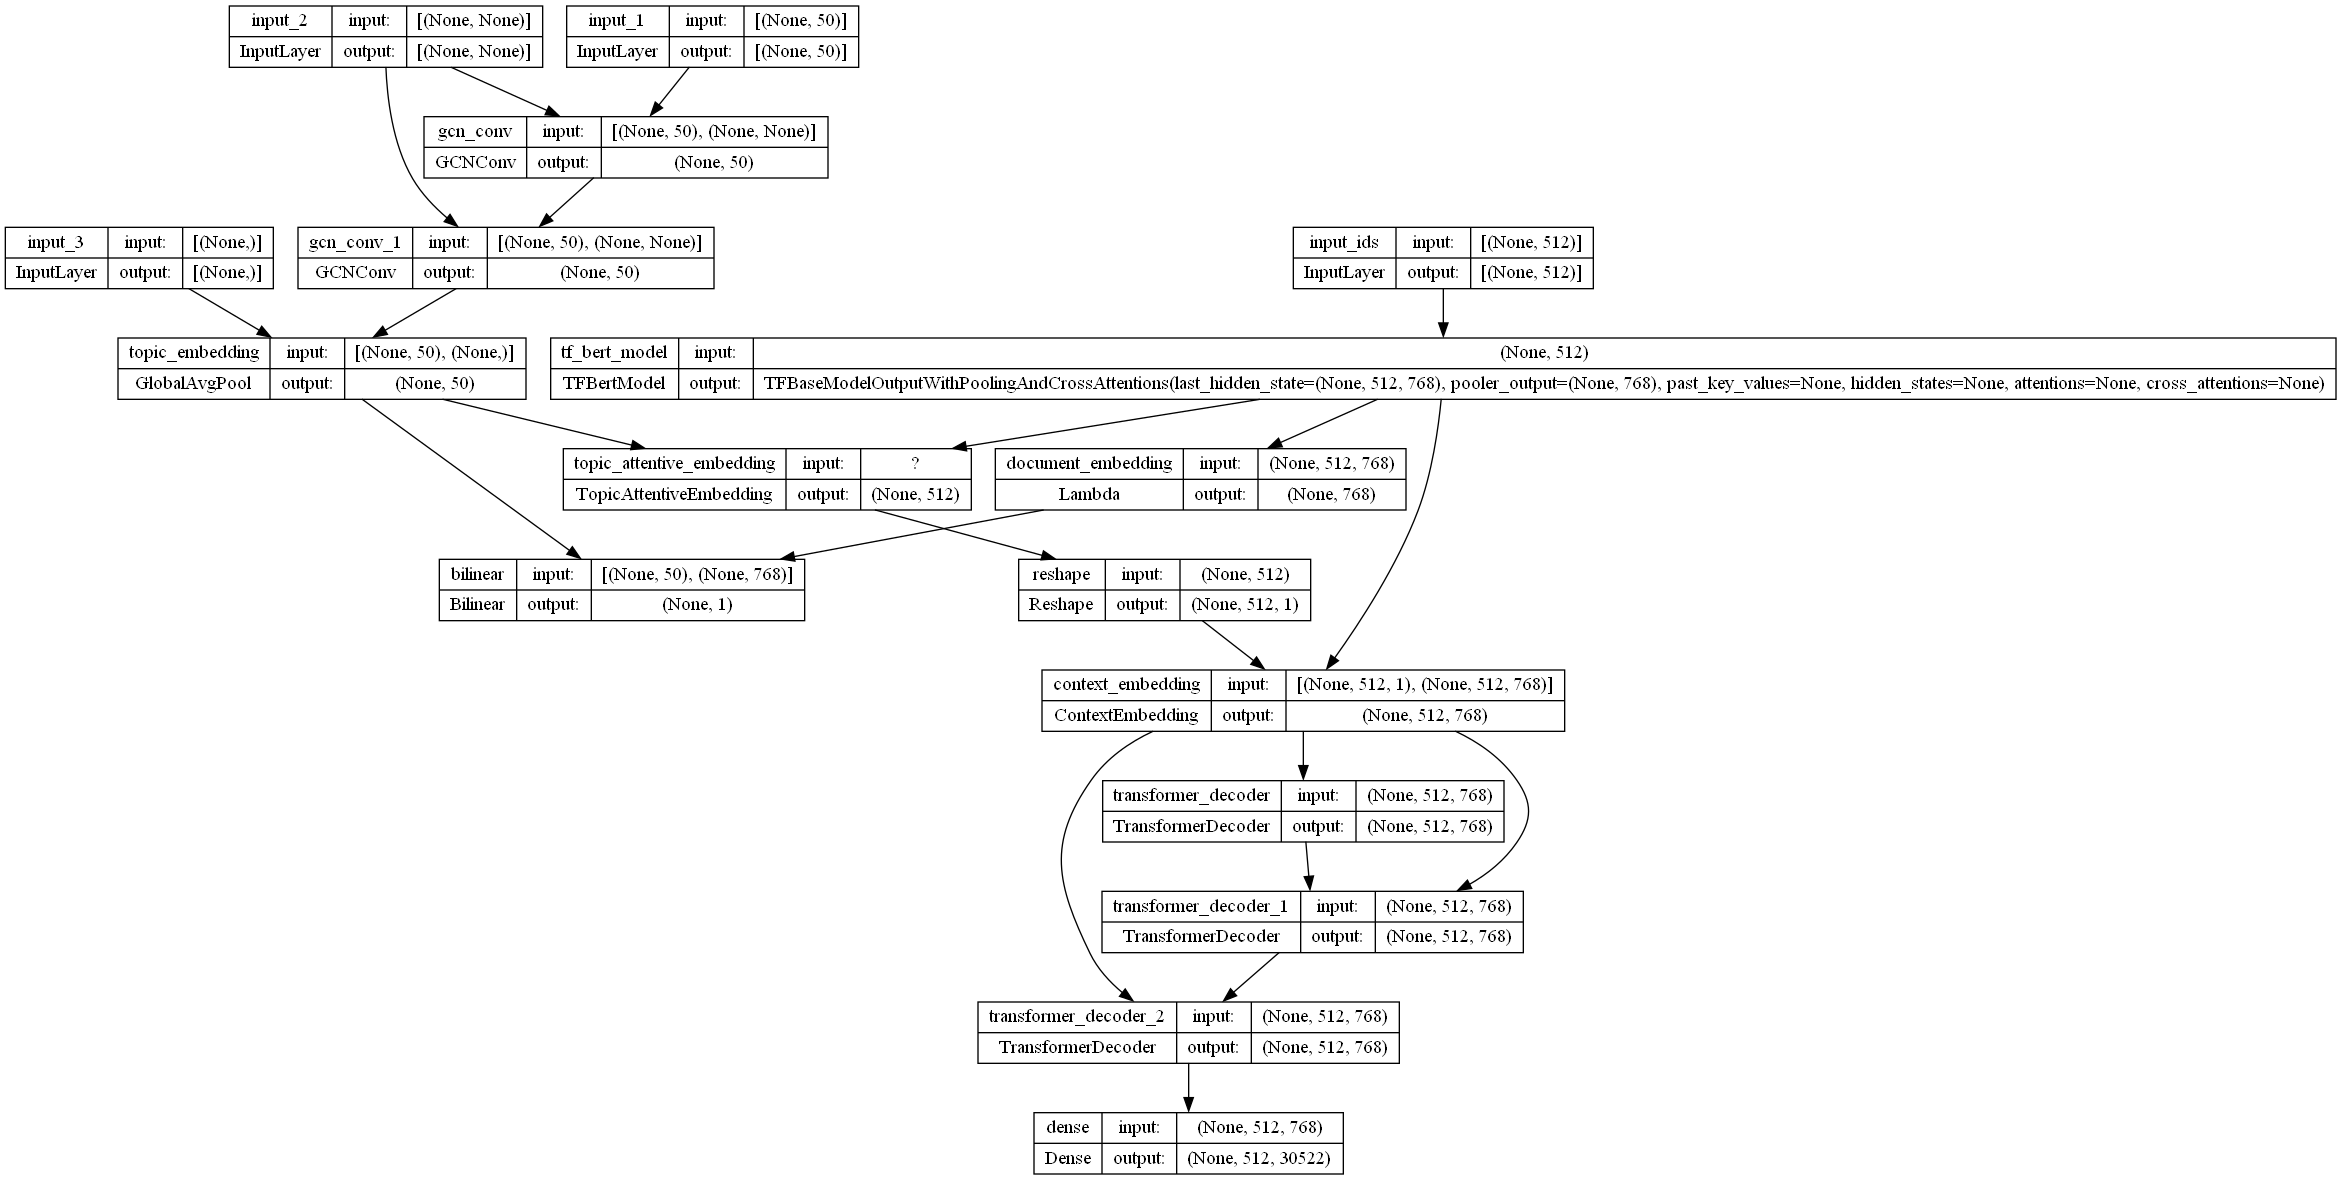

In [22]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'], run_eagerly=True)
# model.summary()
topic_expan_generator = TopicExpanTrainGen(graph_list, documents, documents_labels, batch_size, 4)

In [24]:
from tqdm.keras import TqdmCallback
model.fit(topic_expan_generator, batch_size=64, epochs=epochs, verbose=1, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'model_with_nce/tf_bert_model/bert/encoder/layer_._9/attention/self/dropout_28/dropout/random_uniform/RandomUniform' defined at (most recent call last):
    File "c:\Users\saif8\miniconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\saif8\miniconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\saif8\miniconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "c:\Users\saif8\miniconda3\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\saif8\miniconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\saif8\miniconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\saif8\miniconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "c:\Users\saif8\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "c:\Users\saif8\miniconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\saif8\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\saif8\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\saif8\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\saif8\AppData\Local\Temp\ipykernel_8612\2998988005.py", line 2, in <module>
      model.fit(topic_expan_generator, batch_size=64, epochs=epochs, verbose=1, callbacks=[TqdmCallback(verbose=1)])
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\saif8\AppData\Local\Temp\ipykernel_8612\113156095.py", line 8, in train_step
      similarity_prediction, phrase_prediction = self(inputs, training=True)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\modeling_tf_utils.py", line 1088, in run_call_with_unpacked_inputs
      - **config_class** ([`PretrainedConfig`]) -- A subclass of [`PretrainedConfig`] to use as configuration class
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 1115, in call
      outputs = self.bert(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\modeling_tf_utils.py", line 1088, in run_call_with_unpacked_inputs
      - **config_class** ([`PretrainedConfig`]) -- A subclass of [`PretrainedConfig`] to use as configuration class
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 871, in call
      encoder_outputs = self.encoder(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 556, in call
      for i, layer_module in enumerate(self.layer):
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 562, in call
      layer_outputs = layer_module(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 472, in call
      self_attention_outputs = self.attention(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 388, in call
      self_outputs = self.self_attention(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 331, in call
      attention_probs = self.dropout(inputs=attention_probs, training=training)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\layers\regularization\dropout.py", line 116, in call
      output = control_flow_util.smart_cond(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\layers\regularization\dropout.py", line 112, in dropped_inputs
      return self._random_generator.dropout(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\backend.py", line 2162, in dropout
      return tf.nn.dropout(
Node: 'model_with_nce/tf_bert_model/bert/encoder/layer_._9/attention/self/dropout_28/dropout/random_uniform/RandomUniform'
Detected at node 'model_with_nce/tf_bert_model/bert/encoder/layer_._9/attention/self/dropout_28/dropout/random_uniform/RandomUniform' defined at (most recent call last):
    File "c:\Users\saif8\miniconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\saif8\miniconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\saif8\miniconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "c:\Users\saif8\miniconda3\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\saif8\miniconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\saif8\miniconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\saif8\miniconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "c:\Users\saif8\miniconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "c:\Users\saif8\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "c:\Users\saif8\miniconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\saif8\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\saif8\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\saif8\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\saif8\AppData\Local\Temp\ipykernel_8612\2998988005.py", line 2, in <module>
      model.fit(topic_expan_generator, batch_size=64, epochs=epochs, verbose=1, callbacks=[TqdmCallback(verbose=1)])
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\saif8\AppData\Local\Temp\ipykernel_8612\113156095.py", line 8, in train_step
      similarity_prediction, phrase_prediction = self(inputs, training=True)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\modeling_tf_utils.py", line 1088, in run_call_with_unpacked_inputs
      - **config_class** ([`PretrainedConfig`]) -- A subclass of [`PretrainedConfig`] to use as configuration class
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 1115, in call
      outputs = self.bert(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\modeling_tf_utils.py", line 1088, in run_call_with_unpacked_inputs
      - **config_class** ([`PretrainedConfig`]) -- A subclass of [`PretrainedConfig`] to use as configuration class
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 871, in call
      encoder_outputs = self.encoder(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 556, in call
      for i, layer_module in enumerate(self.layer):
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 562, in call
      layer_outputs = layer_module(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 472, in call
      self_attention_outputs = self.attention(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 388, in call
      self_outputs = self.self_attention(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 331, in call
      attention_probs = self.dropout(inputs=attention_probs, training=training)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\layers\regularization\dropout.py", line 116, in call
      output = control_flow_util.smart_cond(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\layers\regularization\dropout.py", line 112, in dropped_inputs
      return self._random_generator.dropout(
    File "c:\Users\saif8\miniconda3\lib\site-packages\keras\backend.py", line 2162, in dropout
      return tf.nn.dropout(
Node: 'model_with_nce/tf_bert_model/bert/encoder/layer_._9/attention/self/dropout_28/dropout/random_uniform/RandomUniform'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,12,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_with_nce/tf_bert_model/bert/encoder/layer_._9/attention/self/dropout_28/dropout/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[softmax_cross_entropy_with_logits/_70]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,12,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_with_nce/tf_bert_model/bert/encoder/layer_._9/attention/self/dropout_28/dropout/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_step_26701]

In [ ]:
################################################################################
# Build model
################################################################################
from tensorflow import int64
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import tensorflow_ranking

from spektral.layers import GCNConv, GlobalAvgPool, GraphMasking

# n_out = dataset.n_labels

X_in = Input(shape=(50))
A_in = Input(shape=(None,), sparse=True)
I_in = Input(shape=(), dtype=int64)

X = GCNConv(32, activation='relu')([X_in, A_in])
X = GCNConv(32, activation='relu')([X, A_in])
X = GlobalAvgPool()([X, I_in])

shared_bilinear = tensorflow_ranking.keras.layers.Bilinear(32, 32)
X_1 = shared_bilinear([X, X])
X = shared_bilinear([X, X], training=False)

out = Dense(2, activation='softmax')(X)

model = Model(inputs=[X_in, A_in, I_in], outputs=out)


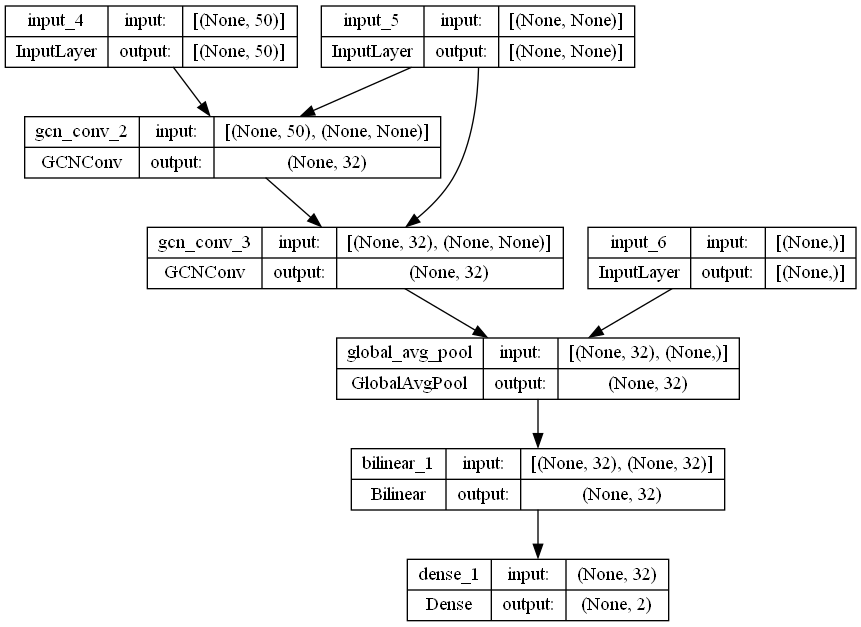

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)